In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from tqdm.auto import tqdm
import itertools
import matplotlib as mpl
import scipy
# from scipy.integrate import cumtrapz
import seaborn as sns
import os
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import re

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax.numpy as jnp
import jax.random as random
import arviz as az

import chart_studio.plotly as py
import chart_studio
import json

import rpgf3lib

warnings.simplefilter(action='ignore', category=UserWarning)

/home/kiran/code/fil-retropgf/rpgf3/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
QUORUM = 4
TOTAL_FUNDING = 510000
MIN_FUNDING = 500
SCORING_FN = 'sum'

In [4]:
# Normalize Project Names: use the best version (without replacement characters) for each Application ID
df = pd.read_csv('../data/ballots-fil-retropgf-3-deidentified.csv')

# First, normalize whitespace and special characters
df['Project Name Normalized'] = (
    df['Project Name']
    .str.strip()
    .str.replace('–', '-', regex=False)
    .str.replace('\'', "'", regex=False)
)

# Create a mapping: for each Application ID, use the first Project Name that doesn't contain
# If all contain, use the first one
def get_canonical_name(group):
    # Prefer names without replacement character
    without_replacement = group[~group['Project Name Normalized'].str.contains('', na=False)]
    if len(without_replacement) > 0:
        return without_replacement.iloc[0]['Project Name Normalized']
    else:
        return group.iloc[0]['Project Name Normalized']

canonical_names = df.groupby('Application ID').apply(get_canonical_name).to_dict()

# Apply the canonical name to all rows
df['Project Name Canonical'] = df['Application ID'].map(canonical_names)

# Verify: check if there are still conflicts after using canonical names
app_id_groups = df.groupby('Application ID')['Project Name Canonical'].nunique()
conflicting = app_id_groups[app_id_groups > 1].index

if len(conflicting) > 0:
    print("Still have conflicts after canonicalization:")
    display(df[df['Application ID'].isin(conflicting)][['Application ID', 'Project Name', 'Project Name Canonical']].drop_duplicates())
else:
    print(f"✓ Successfully normalized: {len(canonical_names)} unique Application IDs")
    print(f"✓ All Application IDs now have unique canonical Project Names")

✓ Successfully normalized: 120 unique Application IDs
✓ All Application IDs now have unique canonical Project Names


/tmp/ipykernel_60923/1479564253.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  canonical_names = df.groupby('Application ID').apply(get_canonical_name).to_dict()


In [5]:
# Parse AI Badgeholder markdown data and add to dataset
def parse_markdown_votes(markdown_path):
    """
    Parse markdown table with project rankings and allocations.
    Returns a list of dicts with project names and vote amounts.
    """
    with open(markdown_path, 'r') as f:
        content = f.read()
    
    # Parse markdown table - skip header rows (lines starting with | Rank | or | ---- |)
    lines = content.strip().split('\n')
    votes = []
    
    for line in lines:
        line = line.strip()
        # Skip empty lines, header rows, and separator rows
        if not line.startswith('|') or 'Rank' in line or '----' in line or not line:
            continue
        
        # Parse table row: | Rank | Project | Allocation (FIL) |
        # Split by | and filter out empty strings
        parts = [p.strip() for p in line.split('|') if p.strip()]
        
        if len(parts) >= 3:
            rank = parts[0]
            project_name = parts[1]
            allocation_str = parts[2]
            
            # Remove commas from allocation and convert to int
            try:
                allocation = int(allocation_str.replace(',', '').strip())
                votes.append({
                    'rank': rank,
                    'project_name': project_name,
                    'allocation': allocation
                })
            except ValueError:
                print(f"Warning: Could not parse allocation '{allocation_str}' for project '{project_name}'")
    
    return votes

# Parse the markdown file
ai_badgeholder_votes = parse_markdown_votes('../data/ai_badgeholder.md')
print(f"Parsed {len(ai_badgeholder_votes)} votes from AI Badgeholder")

# Create a mapping from canonical project names to Application IDs
# Use the existing df to get the mapping
project_to_appid = df[['Project Name Canonical', 'Application ID']].drop_duplicates()
project_to_appid_dict = dict(zip(project_to_appid['Project Name Canonical'], project_to_appid['Application ID']))

# Also create a normalized version for matching (normalize the markdown project names the same way)
def normalize_project_name(name):
    """Normalize project name the same way as in the main dataset"""
    return (
        name.strip()
        .replace('–', '-')
        .replace('\'', "'")
    )

# Match markdown project names to Application IDs
ai_badgeholder_rows = []
badgeholder_name = 'AI Badgeholder'
unmatched_projects = []

for vote in ai_badgeholder_votes:
    project_name = vote['project_name']
    normalized_name = normalize_project_name(project_name)
    
    # Try exact match first (case-insensitive)
    app_id = None
    for canonical_name, aid in project_to_appid_dict.items():
        if normalized_name.lower() == canonical_name.lower():
            app_id = aid
            break
    
    # If still no match, try partial matching (check if markdown name contains canonical name or vice versa)
    if app_id is None:
        for canonical_name, aid in project_to_appid_dict.items():
            # Remove extra whitespace and compare
            normalized_canonical = ' '.join(canonical_name.lower().split())
            normalized_markdown = ' '.join(normalized_name.lower().split())
            
            # Check if one contains the other (for cases with slight variations)
            if normalized_markdown == normalized_canonical or \
               (len(normalized_markdown) > 10 and normalized_markdown in normalized_canonical) or \
               (len(normalized_canonical) > 10 and normalized_canonical in normalized_markdown):
                app_id = aid
                break
    
    if app_id is None:
        unmatched_projects.append(project_name)
        print(f"Warning: Could not match project '{project_name}' to an Application ID")
    else:
        # Get the canonical project name for this Application ID
        canonical_name = df[df['Application ID'] == app_id]['Project Name Canonical'].iloc[0]
        
        ai_badgeholder_rows.append({
            'Voter Wallet Address': badgeholder_name,
            'Application ID': app_id,
            'Project Name': canonical_name,  # Use canonical name
            'Assigned votes': vote['allocation']
        })

print(f"\nSuccessfully matched {len(ai_badgeholder_rows)} out of {len(ai_badgeholder_votes)} projects")
if unmatched_projects:
    print(f"Unmatched projects: {unmatched_projects}")

# Add the AI Badgeholder votes to the main dataframe
if ai_badgeholder_rows:
    ai_badgeholder_df = pd.DataFrame(ai_badgeholder_rows)
    
    # Normalize the new rows the same way as the original data
    ai_badgeholder_df['Project Name Normalized'] = (
        ai_badgeholder_df['Project Name']
        .str.strip()
        .str.replace('–', '-', regex=False)
        .str.replace('\'', "'", regex=False)
    )
    
    # Apply canonical name (should be the same as Project Name since we used canonical names)
    ai_badgeholder_df['Project Name Canonical'] = ai_badgeholder_df['Application ID'].map(canonical_names)
    
    # Append to main dataframe
    df = pd.concat([df, ai_badgeholder_df], ignore_index=True)
    print(f"\n✓ Added {len(ai_badgeholder_rows)} votes from AI Badgeholder")
    print(f"✓ Total rows in dataset: {len(df)}")
else:
    print("\n⚠ No votes were added. Please check the project name matching.")


Parsed 30 votes from AI Badgeholder

Successfully matched 30 out of 30 projects

✓ Added 30 votes from AI Badgeholder
✓ Total rows in dataset: 981


In [6]:
df

,Voter Wallet Address,Application ID,Project Name,Assigned votes,Project Name Normalized,Project Name Canonical
0,Badgeholder 1,1f64b8a1-bdbe-4068-8711-603b6624fb58,Forest,25000,Forest,Forest
1,Badgeholder 1,28288464-b209-4206-84ac-d3d47b340169,Spacescope: API service for the Filecoin ecosy...,30000,Spacescope: API service for the Filecoin ecosy...,Spacescope: API service for the Filecoin ecosy...
2,Badgeholder 1,2bd98798-00fc-4ee2-846b-543627dfae0c,Beryx Filecoin API,20000,Beryx Filecoin API,Beryx Filecoin API
3,Badgeholder 1,32c9890d-111f-4652-92ae-4d538018f11c,Secured Finance,60000,Secured Finance,Secured Finance
4,Badgeholder 1,4499d1d8-a659-41f0-a8ee-845813d3c316,Blockscout Open Source Filecoin Explorer,20000,Blockscout Open Source Filecoin Explorer,Blockscout Open Source Filecoin Explorer
...,...,...,...,...,...,...
976,AI Badgeholder,99448aa8-08fc-4ada-afce-ff05457fe5b8,Axelar Network,6884,Axelar Network,Axelar Network
977,AI Badgeholder,e6cc730e-b8dd-40f3-933a-3b196bd89018,CIDgravity Filecoin Gateway,6679,CIDgravity Filecoin Gateway,CIDgravity Filecoin Gateway
978,AI Badgeholder,b967b145-6917-4800-9a29-c9f54746ad0f,FIP Editors - Filecoin Improvement Proposal Go...,6488,FIP Editors - Filecoin Improvement Proposal Go...,FIP Editors - Filecoin Improvement Proposal Go...
979,AI Badgeholder,7a4f6567-20bf-4ae0-a918-b79ab5ce1758,Multichain Storage,6308,Multichain Storage,Multichain Storage


In [7]:
NUM_VOTERS = df['Voter Wallet Address'].nunique()
print(f'Number of voters: {NUM_VOTERS}')


Number of voters: 31


In [8]:
dff = df[['Voter Wallet Address', 'Application ID', 'Project Name Canonical', 'Assigned votes']]
dff.rename(columns={
    'Voter Wallet Address': 'voterId',
    'Application ID': 'projectId', 
    'Project Name Canonical': 'project',
    'Assigned votes': 'amount'
    }, 
inplace=True)
dff.head()

# dff.to_csv('../data/project_names.csv', index=False)


/tmp/ipykernel_60923/3305430997.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff.rename(columns={


,voterId,projectId,project,amount
0,Badgeholder 1,1f64b8a1-bdbe-4068-8711-603b6624fb58,Forest,25000
1,Badgeholder 1,28288464-b209-4206-84ac-d3d47b340169,Spacescope: API service for the Filecoin ecosy...,30000
2,Badgeholder 1,2bd98798-00fc-4ee2-846b-543627dfae0c,Beryx Filecoin API,20000
3,Badgeholder 1,32c9890d-111f-4652-92ae-4d538018f11c,Secured Finance,60000
4,Badgeholder 1,4499d1d8-a659-41f0-a8ee-845813d3c316,Blockscout Open Source Filecoin Explorer,20000


In [9]:
category_df = pd.read_csv('../data/project2cat.csv')
category_df.rename(columns={
    'Project Name': 'project',
    'Category Name': 'impactCategory'}, 
inplace=True)
category_df = category_df[['project', 'impactCategory']]

# Normalize project names in category_df the same way as in the ballots
# Use Unicode escapes for special characters to avoid parsing issues
en_dash = '\u2013'  # en dash
right_single_quote = '\u2019'  # right single quotation mark
category_df['project_normalized'] = (
    category_df['project']
    .str.strip()
    .str.replace(en_dash, '-', regex=False)
    .str.replace(right_single_quote, "'", regex=False)
)

# Create a mapping from normalized names to canonical names using the df dataframe
# This maps any normalized variation to its canonical name
normalized_to_canonical = df[['Project Name Normalized', 'Project Name Canonical']].drop_duplicates()
normalized_to_canonical = dict(zip(normalized_to_canonical['Project Name Normalized'], 
                                   normalized_to_canonical['Project Name Canonical']))

# Map normalized category_df project names to canonical names
category_df['project'] = category_df['project_normalized'].map(normalized_to_canonical).fillna(category_df['project_normalized'])
category_df = category_df[['project', 'impactCategory']]  # Drop the temporary normalized column

# Rename categories
category_df.loc[category_df['impactCategory'] == 'Education and Outreach', 'impactCategory'] = 'Edu & Outreach'
category_df.loc[category_df['impactCategory'] == 'Tooling and Utilities', 'impactCategory'] = 'Tooling & Utilities'
category_df.loc[category_df['impactCategory'] == 'Collective Governance', 'impactCategory'] = 'Governance'
category_df.loc[category_df['impactCategory'] == 'Infrastructure and Dependencies', 'impactCategory'] = 'Infra & Deps'
category_df.loc[category_df['impactCategory'] == 'Protocol Research & Development', 'impactCategory'] = 'Protocol R&D'
category_df.loc[category_df['impactCategory'] == 'Products and End User UX', 'impactCategory'] = 'Product & UX'

In [10]:
dff = dff.merge(category_df, on='project', how='left')
dff.rename(columns={'impactCategory': 'category'}, inplace=True)

In [11]:
dff.head()

,voterId,projectId,project,amount,category
0,Badgeholder 1,1f64b8a1-bdbe-4068-8711-603b6624fb58,Forest,25000,Infra & Deps
1,Badgeholder 1,28288464-b209-4206-84ac-d3d47b340169,Spacescope: API service for the Filecoin ecosy...,30000,Tooling & Utilities
2,Badgeholder 1,2bd98798-00fc-4ee2-846b-543627dfae0c,Beryx Filecoin API,20000,Tooling & Utilities
3,Badgeholder 1,32c9890d-111f-4652-92ae-4d538018f11c,Secured Finance,60000,Infra & Deps
4,Badgeholder 1,4499d1d8-a659-41f0-a8ee-845813d3c316,Blockscout Open Source Filecoin Explorer,20000,Infra & Deps


In [12]:
# get nan category projects
nan_category_projects = dff[dff['category'].isna()]['project'].unique()
print(f'Number of projects with no category: {len(nan_category_projects)}')
# print the projects
print(nan_category_projects)

Number of projects with no category: 2
['GainForest: The world’s first community-owned data commons for nature impact'
 'Oku.trade - Filecoin’s premier DeFi aggregator for deep liquidity, LP management and cross-chain interoperability - 0% fee swaps & bridges.']


In [13]:
# manually add category for these projects
dff.loc[dff['project'] == 'GainForest: The world’s first community-owned data commons for nature impact', 'category'] = 'Product & UX'
dff.loc[dff['project'] == 'Oku.trade - Filecoin’s premier DeFi aggregator for deep liquidity, LP management and cross-chain interoperability - 0% fee swaps & bridges.', 'category'] = 'Product & UX'

In [14]:
# get nan category projects
nan_category_projects = dff[dff['category'].isna()]['project'].unique()
print(f'Number of projects with no category: {len(nan_category_projects)}')
# print the projects
print(nan_category_projects)

Number of projects with no category: 0
[]


In [15]:
projectid2name = {}
projectname2id = {}
for i, row in dff.iterrows():
    projectid2name[row['projectId']] = row['project']
    projectname2id[row['project']] = row['projectId']

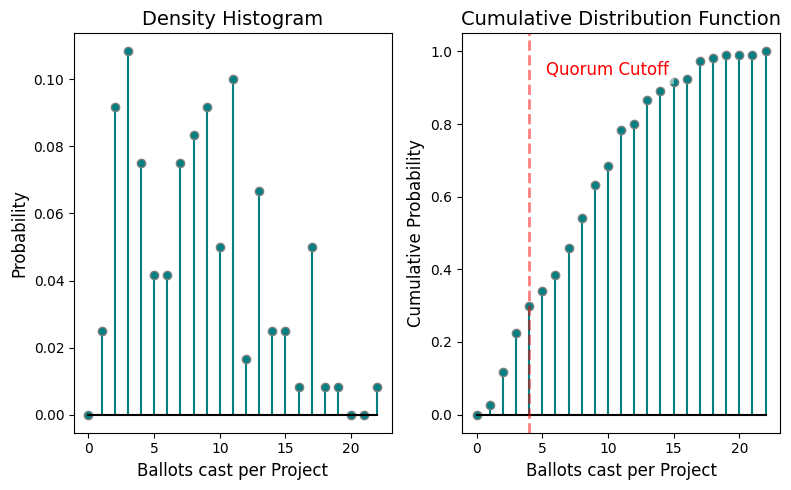

In [16]:
rpgf3lib.votes_distribution_stem(dff, quorum_cutoff=QUORUM, save_fp='../figures/votes_distribution.png')

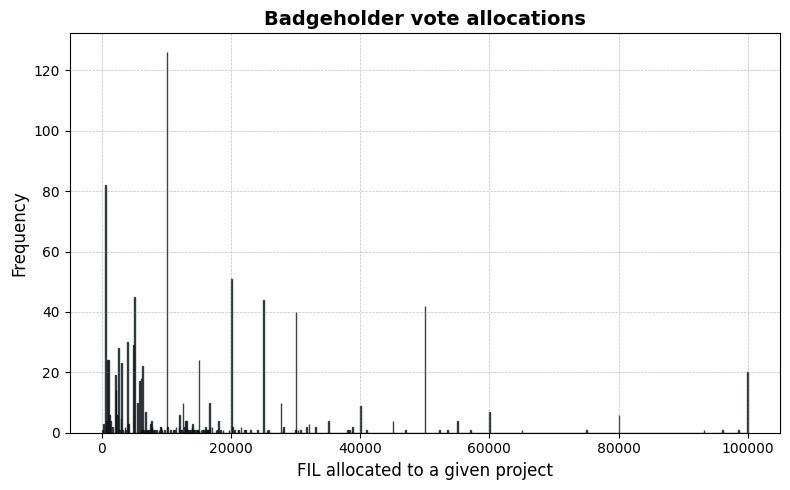

In [17]:
rpgf3lib.votes_per_project_histogram(dff, save_fp='../figures/votes_per_project.png')

In [18]:
dff['amount'].value_counts()

amount
10000    126
500       82
20000     51
5000      45
25000     44
        ... 
6884       1
6679       1
6488       1
6308       1
6139       1
Name: count, Length: 165, dtype: int64

In [19]:
allocations, eliminated, reasons, stats, failed_df, success_df = rpgf3lib.run_allocation_analysis(
    dff,
    quorum_cutoff=QUORUM,
    min_funding=MIN_FUNDING,
    total_funding=TOTAL_FUNDING,
    project_names=projectid2name,
    scoring_fn='sum',
    verbose=False
)

In [20]:
print(f'Failed {len(failed_df)} projects')
print(f'Success {len(success_df)} projects')
print(f'Total {len(dff.groupby("projectId").size())} projects')

Failed 29 projects
Success 91 projects
Total 120 projects


In [35]:
failed_df.to_csv('../data/failed_projects_withAI.csv', index=False)
success_df.to_csv('../data/successful_projects_withAI.csv', index=False)

In [22]:
failed_df

,Project Name,Vote Count,Score,Round,Reason,category
0,WarmWeb,3,19594,1,Failed quorum with 3 votes,Governance
1,4EVERLAND,2,7866,1,Failed quorum with 2 votes,Tooling & Utilities
2,ETHAccra,1,2118,1,Failed quorum with 1 votes,Edu & Outreach
3,Oku.trade - Filecoin’s premier DeFi aggregator...,3,2503,1,Failed quorum with 3 votes,Product & UX
4,OP Medicine - Filecoin-Powered Healthcare Infr...,3,22618,1,Failed quorum with 3 votes,Infra & Deps
5,Filecoin Address Drainer,3,5279,1,Failed quorum with 3 votes,Tooling & Utilities
6,MYRAD,3,12496,1,Failed quorum with 3 votes,Product & UX
7,IPFS及Filecoin价值资讯传递（南山居士Hill）,2,6895,1,Failed quorum with 2 votes,Edu & Outreach
8,Cyberport Data Integration,2,17740,1,Failed quorum with 2 votes,Governance
9,FILCAPETOWN,1,2118,1,Failed quorum with 1 votes,Edu & Outreach


In [23]:
list(success_df['Project Name'].unique())

['FilOz - Advancing the Filecoin Protocol',
 'Filecoin Onchain Cloud (FOC) - Verifiable Storage, Retrieval, and Payments',
 'FIL-B (FIL Builders) DX and Community',
 'go-libp2p',
 'Filecoin Data Portal',
 'drand - the distributed randomness beacon project powering the League of Entropy and Filecoin Leader Election',
 'Curio Storage',
 'UCAN',
 'Lotus, Builtin Actors, and ref-FVM - Core Filecoin Protocol Implementations',
 'Secured Finance',
 'FilPonto: Public goods chain infrastructure & collaborations support for Filecoin',
 'Filscan Explorer',
 'Crossfi',
 'ND Labs',
 'Filliquid',
 'Blockscout Open Source Filecoin Explorer',
 'Chain.Love',
 'Forest',
 'Eastore',
 'Lily: blockchain data extraction for Filecoin',
 'Beryx Filecoin Explorer',
 'Boost',
 'Lighthouse',
 'Beryx Filecoin API',
 'FIP Editors - Filecoin Improvement Proposal Governance',
 'filecoin-checker',
 'Asia-SPWG',
 'Filecoin Beam',
 'Drips',
 'FIP 100 Research & Development',
 'Old Faithful',
 'chainfee',
 'OrbitChina',

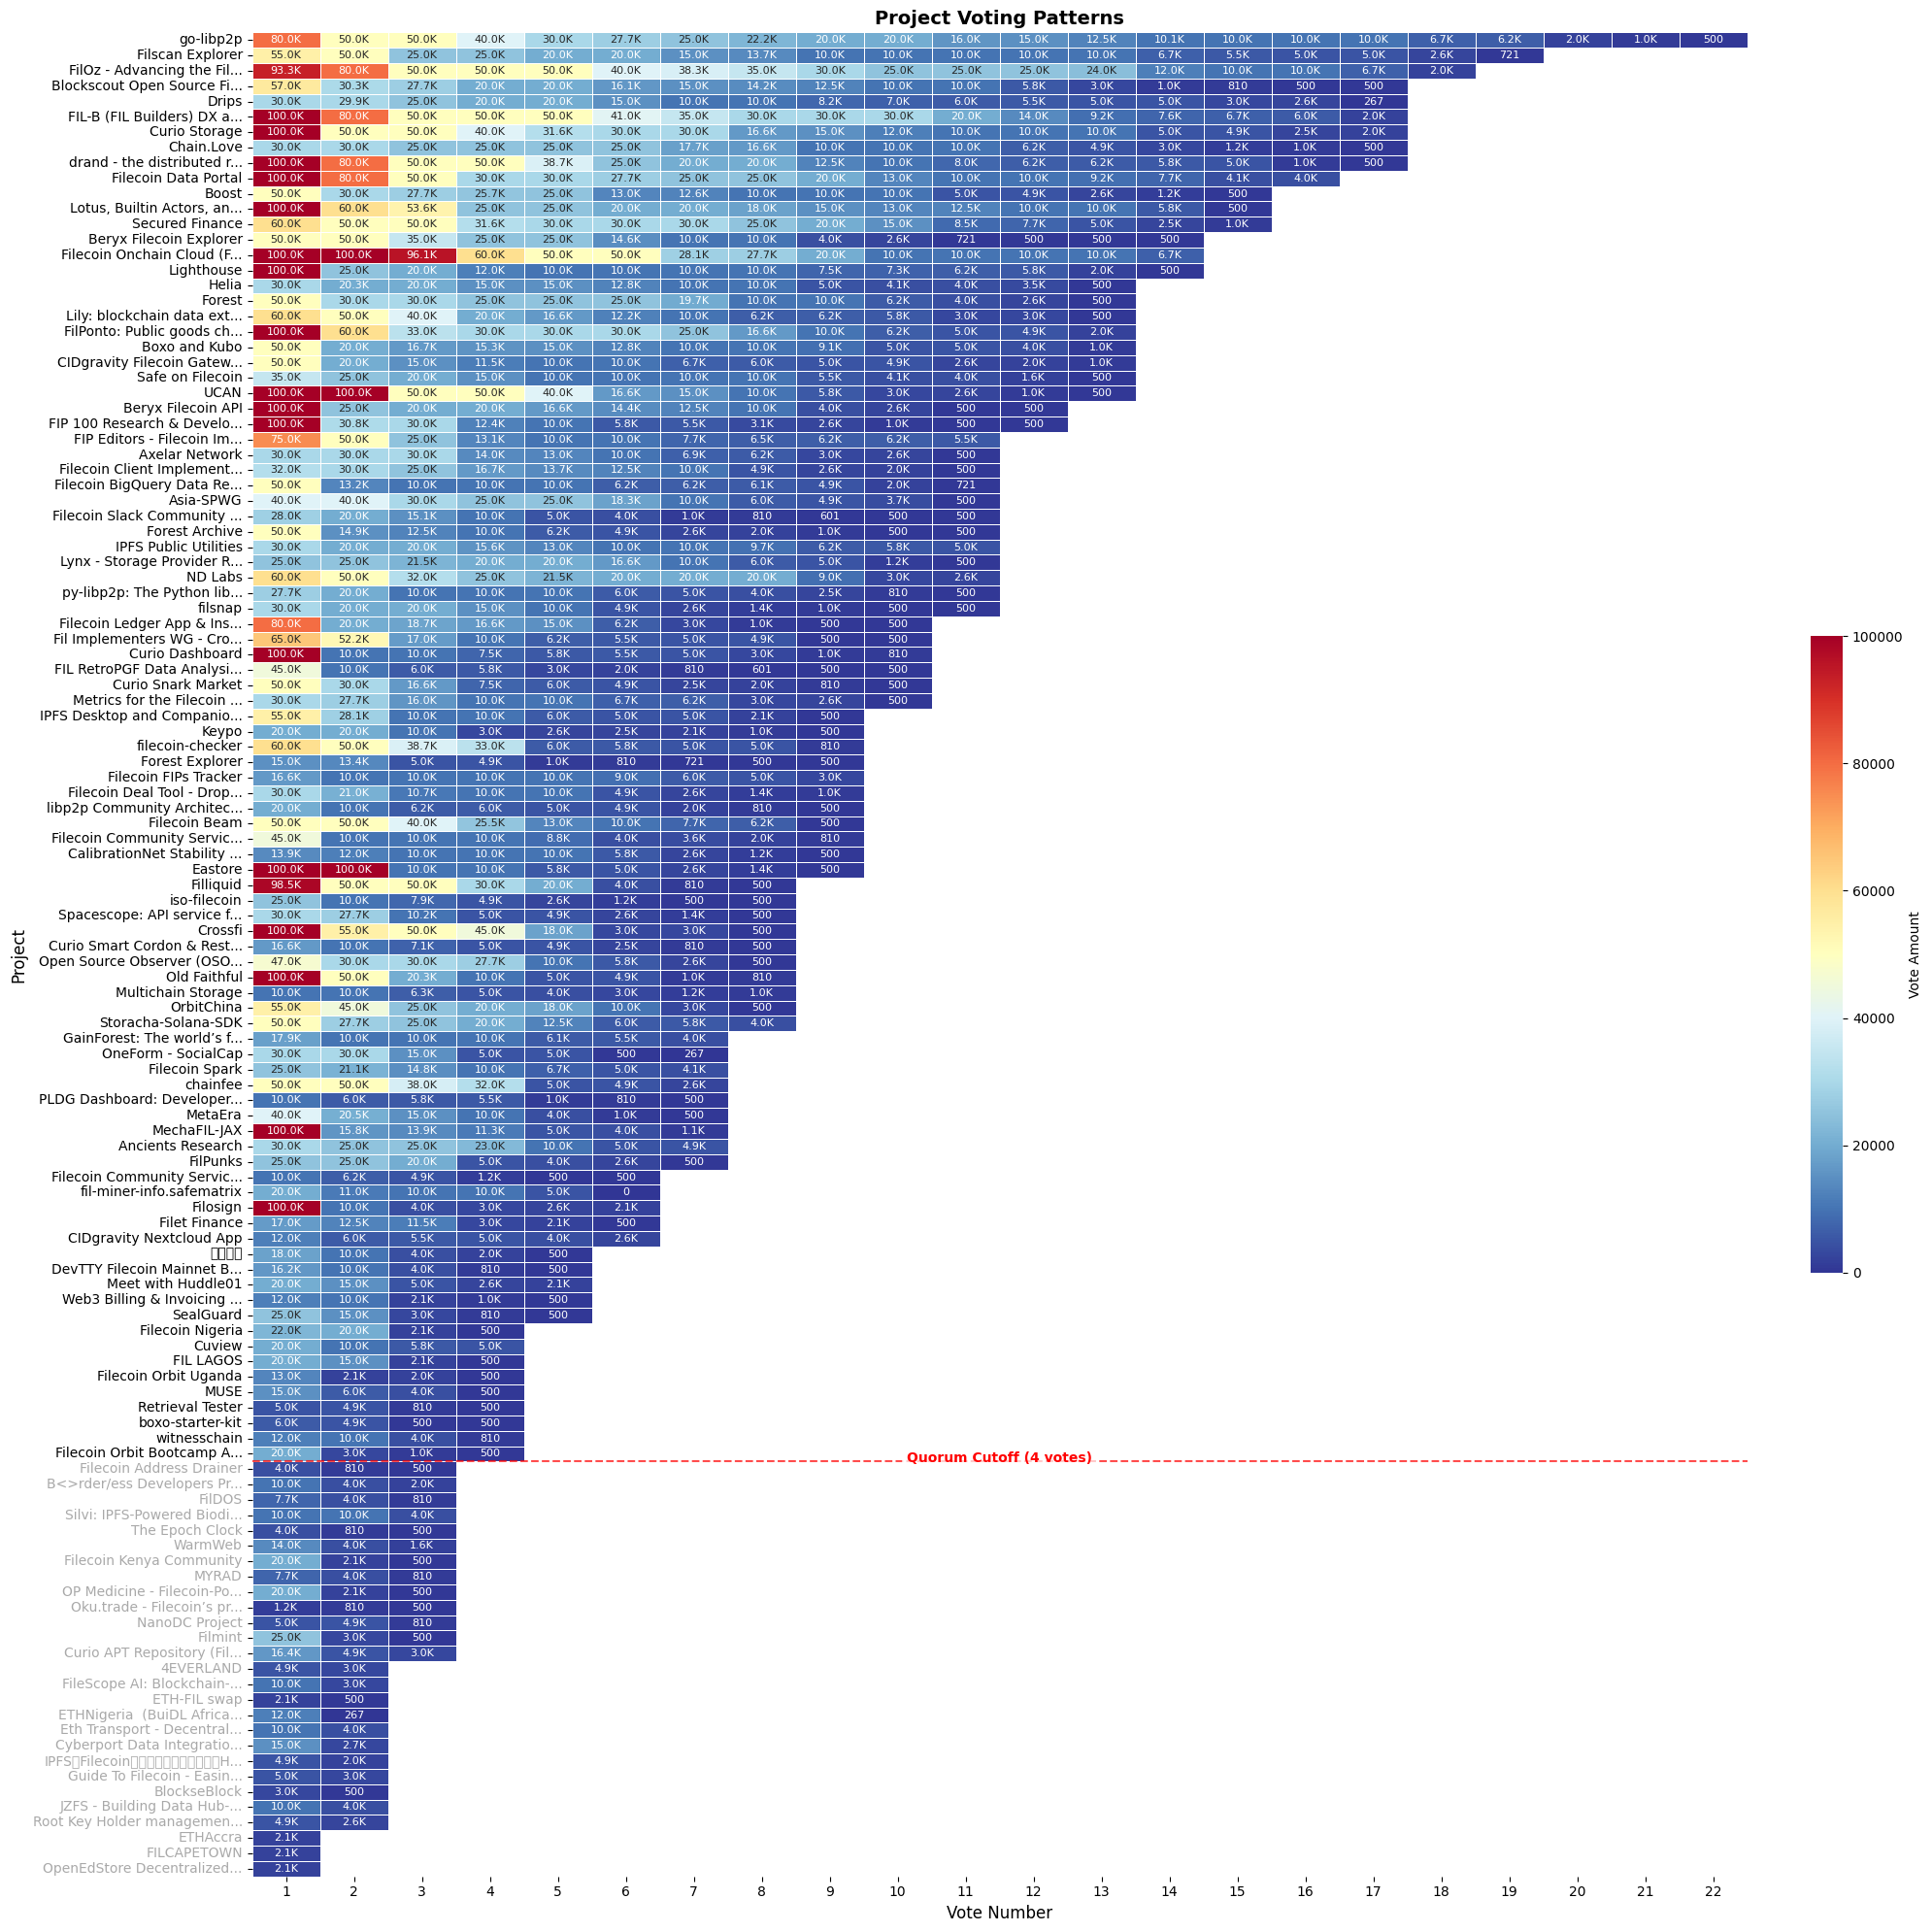

In [24]:
rpgf3lib.project_patterns_withname(
    dff, 
    figsize=(20, 20), 
    save_fp='../figures/project_patterns.png',
    quorum_threshold=QUORUM
)

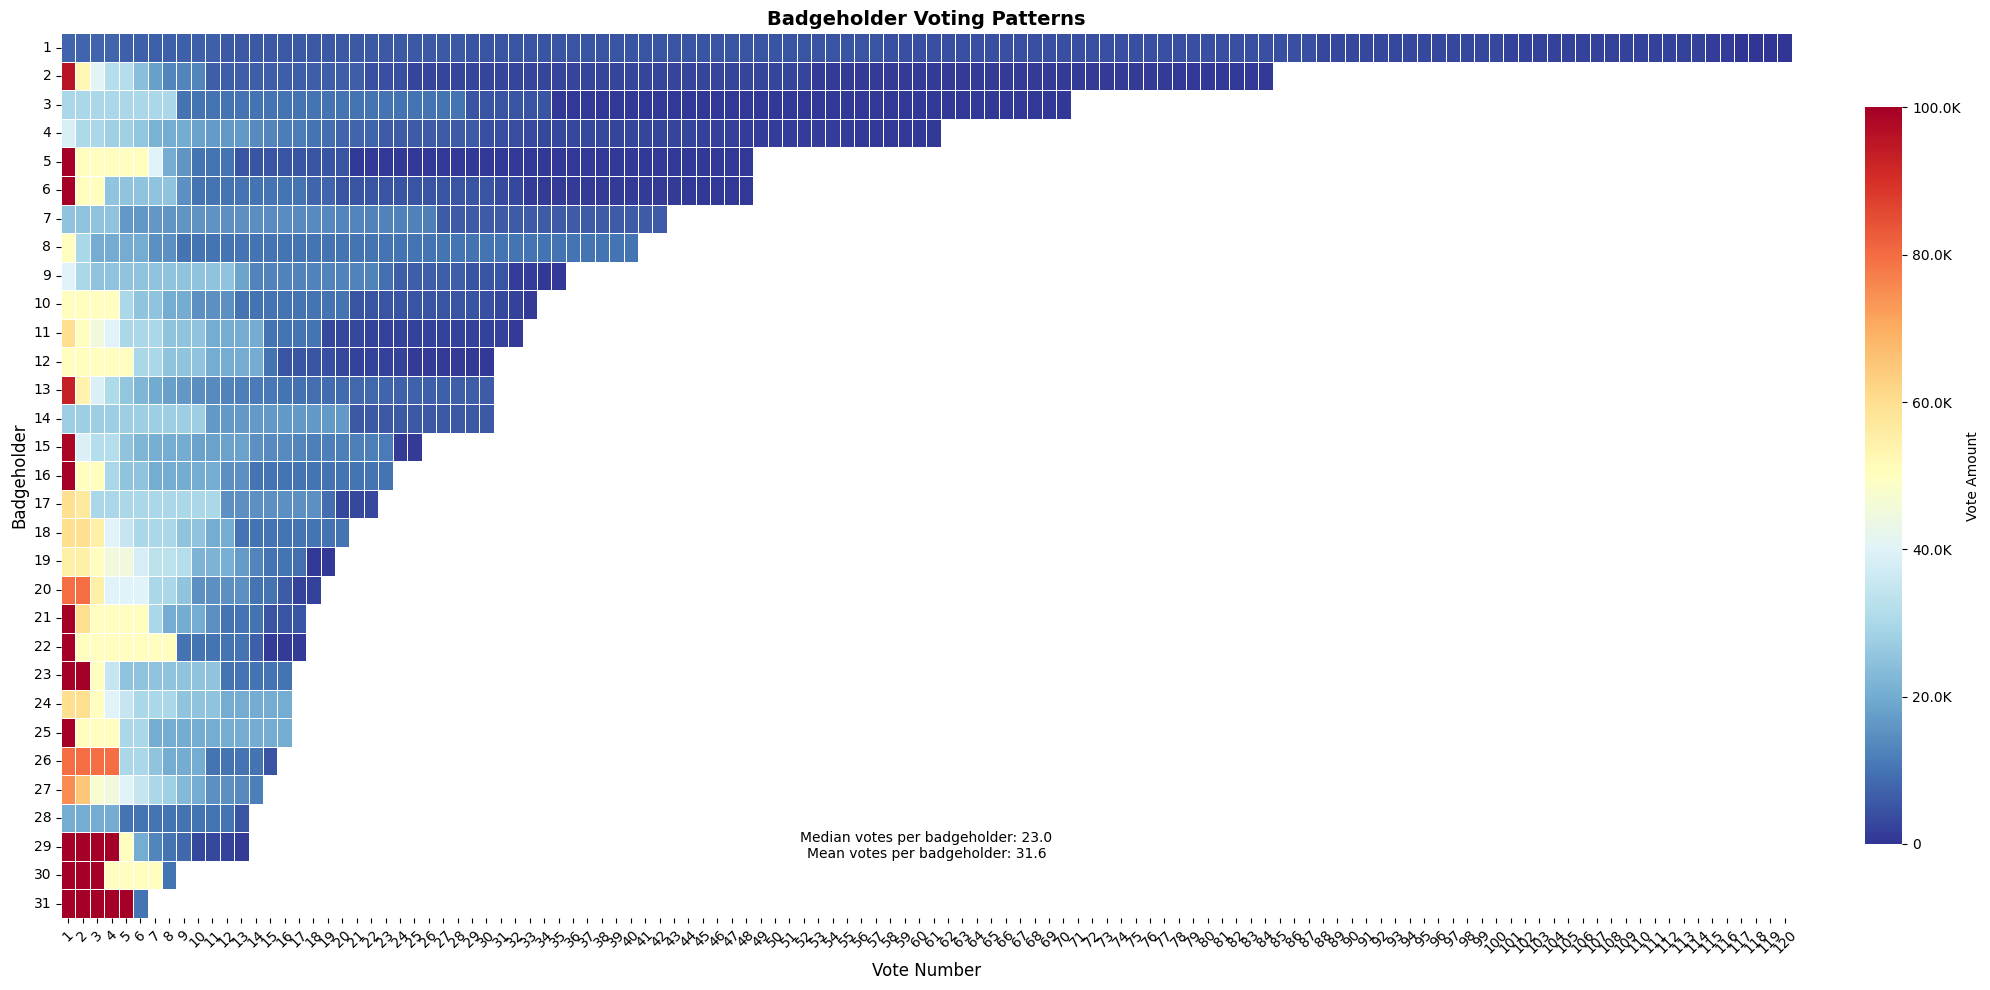

In [25]:
rpgf3lib.badgeholder_patterns2(dff, figsize=(20, 10), save_fp='../figures/badgeholder_patterns.png')

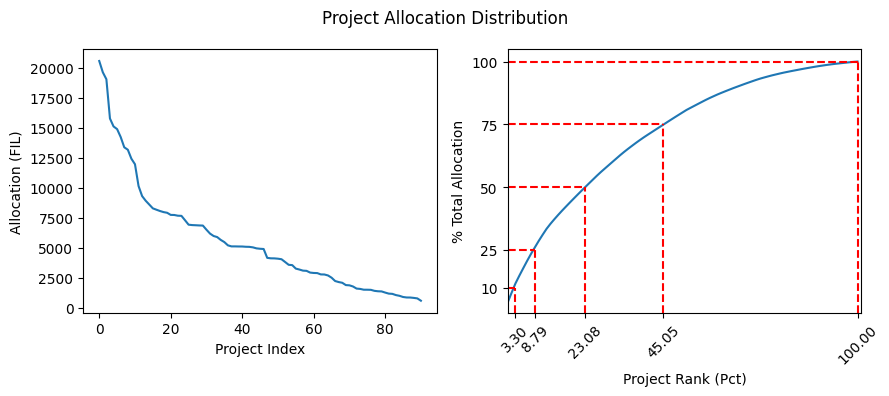

In [26]:
rpgf3lib.project_distribution_patterns(allocations, figsize=(9,4), save_fp='../figures/project_distribution.png')

In [27]:
upload_to_plotly = False

plotly_fig = rpgf3lib.plot_allocations_sunburst(success_df, 
                                                show_project_labels=True,
                                                save_fp='../figures/rpgf3_project_allocations.png')
plotly_fig.show()
if upload_to_plotly:
    with open(os.path.join(os.environ['HOME'], 'code', 'cel', 'auth', 'plotly.json'), 'r') as fp:
        plotly_auth = json.load(fp)
    chart_studio.tools.set_credentials_file(username=plotly_auth['username'], api_key=plotly_auth['api_key'])
    py.plot(plotly_fig, filename='rpgf2_project_allocations', auto_open=True)

Input DataFrame shape: (91, 6)
DataFrame columns: ['Project Name', 'Vote Count', 'Average Score', 'Std Dev', 'Final Allocation (FIL)', 'category']
Sample of input data:
                                         Project Name  Vote Count  \
42            FilOz - Advancing the Filecoin Protocol          18   
81  Filecoin Onchain Cloud (FOC) - Verifiable Stor...          14   
28              FIL-B (FIL Builders) DX and Community          17   
22                                          go-libp2p          22   
64                               Filecoin Data Portal          16   

    Average Score  Std Dev  Final Allocation (FIL)             category  
42       33686.44 24512.14                20571.28         Protocol R&D  
81       41332.00 35426.63                19631.25  Tooling & Utilities  
28       33028.24 27135.63                19048.81       Edu & Outreach  
22       21140.73 19377.73                15778.88         Infra & Deps  
64       27853.81 27385.75                1511

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

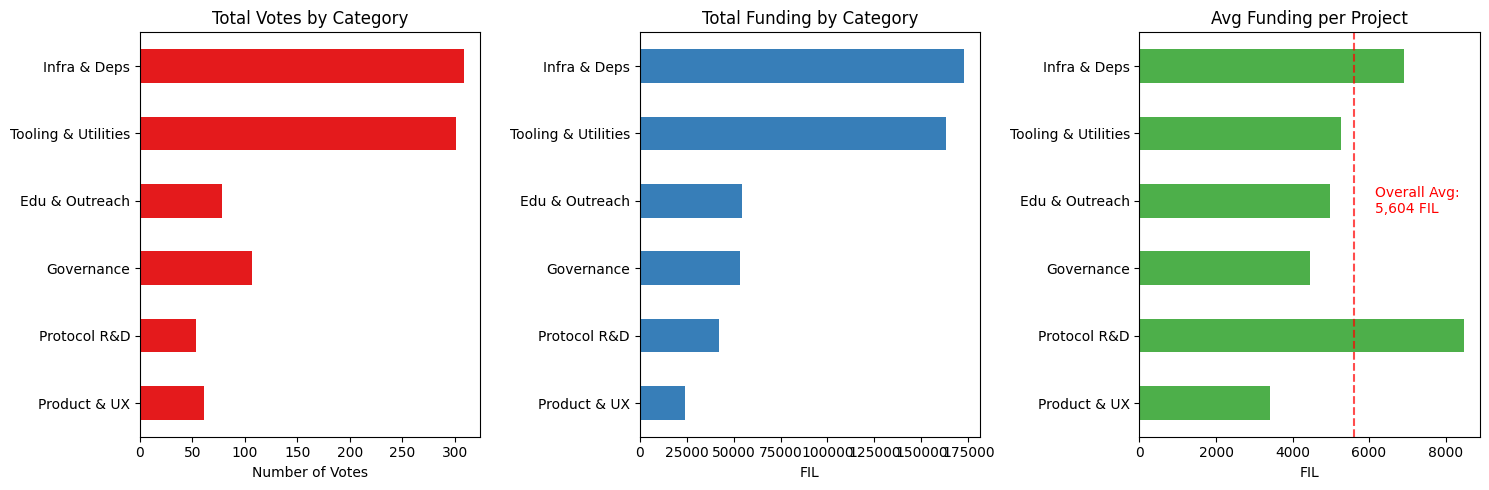

In [28]:
f = rpgf3lib.plot_category_metrics(
    success_df, 
    style='bar',
    save_fp='../figures/category_metrics.png'
)

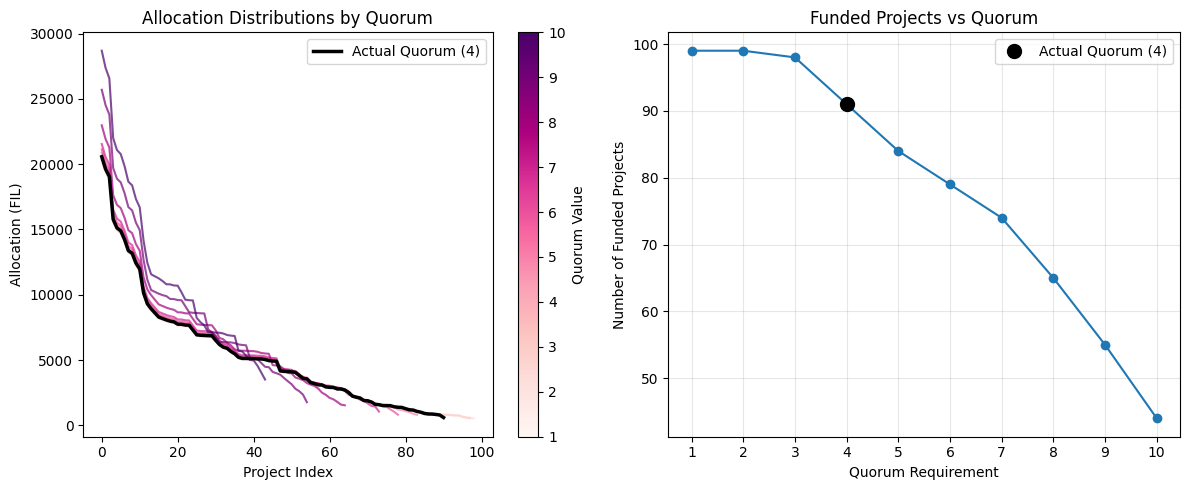

In [29]:
f = rpgf3lib.plot_quorum_sweep(
    dff, 
    actual_quorum=QUORUM,
    min_funding=MIN_FUNDING,
    total_funding=TOTAL_FUNDING,
    save_fp='../figures/quorum_sweep.png'
)


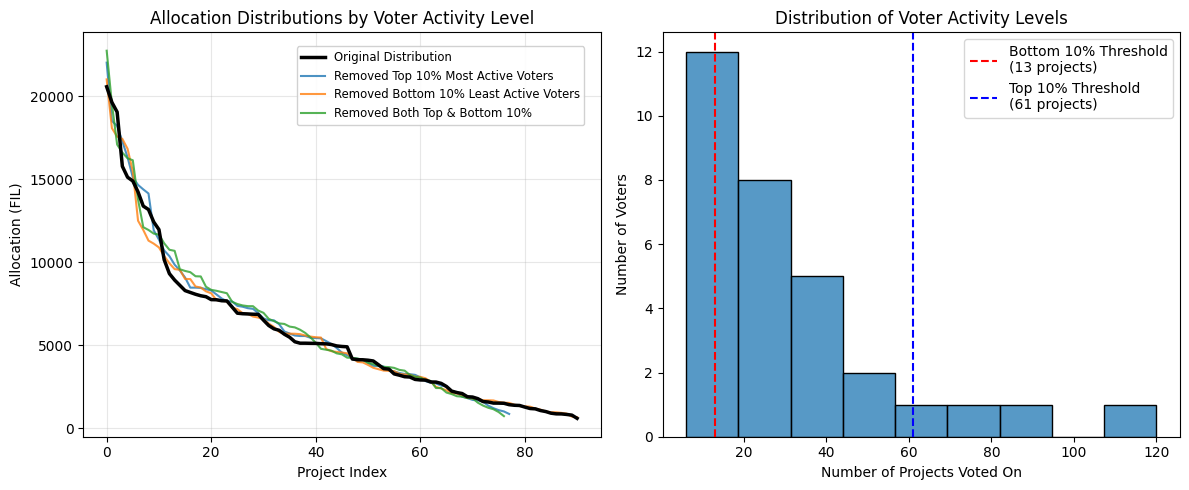

In [30]:
f = rpgf3lib.plot_temperature_analysis(
    dff, 
    quorum_cutoff=QUORUM,
    min_funding=MIN_FUNDING,
    total_funding=TOTAL_FUNDING,
    save_fp='../figures/temperature_analysis.png'
)


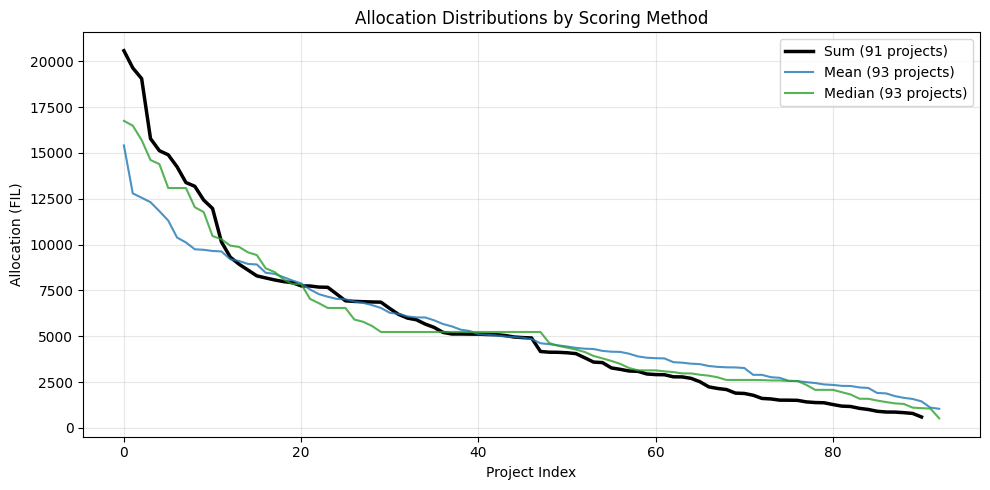

In [31]:
f = rpgf3lib.plot_scoring_comparison(
    dff, 
    quorum_cutoff=QUORUM,
    min_funding=MIN_FUNDING,
    total_funding=TOTAL_FUNDING,
    save_fp='../figures/scoring_comparison.png'
)

In [32]:
bootstrap_allocations = rpgf3lib.bootstrap_allocation_distribution(
    dff, 
    n_samples=1000,
    min_voters=28, 
    quorum_cutoff=QUORUM, 
    min_funding=MIN_FUNDING, 
    total_funding=TOTAL_FUNDING, 
    sample_size=None  # choose between min_voters and total voters randomly
)

 10%|▉         | 98/1000 [00:03<00:32, 27.81it/s]


KeyboardInterrupt: 

In [ ]:
print(len(bootstrap_allocations))

In [ ]:
rpgf3lib.plot_bootstrap_distribution(
    bootstrap_allocations, 
    allocations, 
    save_fp='../figures/bootstrap_allocation_distribution.png'
)

In [ ]:
success_df['PctOfTotal'] = success_df['Final Allocation (FIL)'] / success_df['Final Allocation (FIL)'].sum()*100
success_df.sort_values('PctOfTotal', ascending=False).head()
success_df.head()

In [ ]:
xx = success_df.head()
xx['PctOfTotal'].sum()

In [33]:
success_df['Final Allocation (FIL)'].describe()


count      91.00
mean     5604.40
std      4513.08
min       597.71
25%      2122.09
50%      4926.68
75%      7674.91
max     20571.28
Name: Final Allocation (FIL), dtype: float64

In [34]:
success_df['Final Allocation (FIL)'].median()

np.float64(4926.676443584333)

In [36]:
success_df.sort_values('Vote Count', ascending=False).head()

,Project Name,Vote Count,Average Score,Std Dev,Final Allocation (FIL),category
22,go-libp2p,22,21140.73,19377.73,15778.88,Infra & Deps
88,Filscan Explorer,19,15750.05,14733.29,10152.41,Tooling & Utilities
42,FilOz - Advancing the Filecoin Protocol,18,33686.44,24512.14,20571.28,Protocol R&D
52,Curio Storage,17,24685.06,25058.14,14236.94,Infra & Deps
25,drand - the distributed randomness beacon proj...,17,25824.76,28989.21,14894.26,Infra & Deps


In [ ]:
position_analysis_df = success_df[['Project Name', 'Vote Count', 'Final Allocation (FIL)']]
position_analysis_df['projects_alphabet_pos'] = position_analysis_df['Project Name'].apply(lambda x: ord(x.strip()[0].lower()) - ord('a'))

In [ ]:
def correlation_model_votes(x, y):
    # Priors for means and standard deviations of x and y
    mu_x = numpyro.sample('mu_x', dist.Normal(0, 10))
    sigma_x = numpyro.sample('sigma_x', dist.Exponential(1))
    
    mu_y = numpyro.sample('mu_y', dist.Normal(0, 10))
    sigma_y = numpyro.sample('sigma_y', dist.Exponential(1))
    
    # Prior for the correlation coefficient
    rho = numpyro.sample('rho', dist.Uniform(-1, 1))
    
    # Covariance matrix
    covariance = jnp.array([
        [sigma_x**2, rho * sigma_x * sigma_y],
        [rho * sigma_x * sigma_y, sigma_y**2]
    ])
    
    # Sampling from a bivariate normal distribution
    numpyro.sample('obs', dist.MultivariateNormal(loc=jnp.array([mu_x, mu_y]), covariance_matrix=covariance), obs=jnp.column_stack((x, y)))

def correlation_model_allocation(x, y):
    # Adjust priors to match the scale of the data
    mu_x = numpyro.sample('mu_x', dist.Normal(np.mean(x), 10))
    sigma_x = numpyro.sample('sigma_x', dist.Exponential(1))
    
    # Use more appropriate priors for y given the scale of allocations
    mu_y = numpyro.sample('mu_y', dist.Normal(np.mean(y), 1000))  # Increased scale
    sigma_y = numpyro.sample('sigma_y', dist.Exponential(1000))  # Increased scale
    
    # Prior for the correlation coefficient
    rho = numpyro.sample('rho', dist.Uniform(-1, 1))
    
    # Covariance matrix
    covariance = jnp.array([
        [sigma_x**2, rho * sigma_x * sigma_y],
        [rho * sigma_x * sigma_y, sigma_y**2]
    ])
    
    # Sampling from a bivariate normal distribution
    numpyro.sample('obs', dist.MultivariateNormal(loc=jnp.array([mu_x, mu_y]), covariance_matrix=covariance), obs=jnp.column_stack((x, y)))

In [ ]:
nuts_kernel = NUTS(correlation_model_votes)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)

# Run MCMC
rng_key = random.PRNGKey(0)
x_data = position_analysis_df['projects_alphabet_pos'].values
y1_data = position_analysis_df['Vote Count'].values  # Use unsorted Vote Count
mcmc.run(rng_key, x=jnp.array(x_data), y=jnp.array(y1_data))

# mcmc.print_summary()
posterior_samples_votes = mcmc.get_samples()
rho_samples_votes = posterior_samples_votes['rho']

print(f"Modelled Pearson correlation coefficient of {np.mean(rho_samples_votes):.2f}")
print(f"With 95% credible intervals of the correlation coefficient being between {np.percentile(rho_samples_votes,5):.2f} and {np.percentile(rho_samples_votes,95):.2f}")

In [ ]:
nuts_kernel = NUTS(correlation_model_allocation)
n_samples = 1000
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=n_samples)

# Run MCMC
rng_key = random.PRNGKey(0)
x_data = position_analysis_df['projects_alphabet_pos'].values
y2_data = position_analysis_df['Final Allocation (FIL)'].values  # Use unsorted Vote Count
mcmc.run(rng_key, x=jnp.array(x_data), y=jnp.array(y2_data))

# mcmc.print_summary()
posterior_samples_funding = mcmc.get_samples()
rho_samples_funding = posterior_samples_funding['rho']

print(f"Modelled Pearson correlation coefficient of {np.mean(rho_samples_funding):.2f}")
print(f"With 95% credible intervals of the correlation coefficient being between {np.percentile(rho_samples_funding,5):.2f} and {np.percentile(rho_samples_funding,95):.2f}")

In [ ]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Create letter labels for x-axis
unique_positions = sorted(position_analysis_df['projects_alphabet_pos'].unique())
letter_labels = [chr(int(pos) + ord('A')) for pos in unique_positions]

# Left plot - Votes
x_data = position_analysis_df['projects_alphabet_pos'].values
y1_data = position_analysis_df['Vote Count'].values

# Generate lines for votes plot
x_line = np.linspace(min(x_data), max(x_data), 100)
y1_lines = []
for i in range(n_samples):
    rho = posterior_samples_votes['rho'][i]
    mu_x = posterior_samples_votes['mu_x'][i]
    mu_y = posterior_samples_votes['mu_y'][i]
    sigma_x = posterior_samples_votes['sigma_x'][i]
    sigma_y = posterior_samples_votes['sigma_y'][i]
    
    beta = rho * sigma_y / sigma_x
    y = mu_y + beta * (x_line - mu_x)
    y1_lines.append(y)

y1_lines = np.array(y1_lines)
y1_mean = np.mean(y1_lines, axis=0)
y1_lower = np.percentile(y1_lines, 2.5, axis=0)
y1_upper = np.percentile(y1_lines, 97.5, axis=0)

# Plot votes
ax1.scatter(x_data, y1_data, alpha=0.5, label='Data')
ax1.plot(x_line, y1_mean, color='red', label='Posterior Mean Regression')
ax1.fill_between(x_line, y1_lower, y1_upper, color='red', alpha=0.2, label='95% Credible Interval')

correlation_text = (f"Correlation: {np.mean(posterior_samples_votes['rho']):.2f}\n"
                   f"95% CI: [{np.percentile(posterior_samples_votes['rho'],5):.2f}, "
                   f"{np.percentile(posterior_samples_votes['rho'],95):.2f}]")
ax1.text(0.05, 0.95, correlation_text, transform=ax1.transAxes, 
         bbox=dict(facecolor='white', alpha=0.8), verticalalignment='top')

ax1.set_xticks(unique_positions)
ax1.set_xticklabels(letter_labels)
ax1.set_xlabel('Project First Letter')
ax1.set_ylabel('Number of Votes')
ax1.set_title('Project First Letter vs Number of Votes')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Right plot - Funding
y2_data = position_analysis_df['Final Allocation (FIL)'].values

# Generate lines for funding plot
y2_lines = []
for i in range(n_samples):
    rho = posterior_samples_funding['rho'][i]
    mu_x = posterior_samples_funding['mu_x'][i]
    mu_y = posterior_samples_funding['mu_y'][i]
    sigma_x = posterior_samples_funding['sigma_x'][i]
    sigma_y = posterior_samples_funding['sigma_y'][i]
    
    beta = rho * sigma_y / sigma_x
    y = mu_y + beta * (x_line - mu_x)
    y2_lines.append(y)

y2_lines = np.array(y2_lines)
y2_mean = np.mean(y2_lines, axis=0)
y2_lower = np.percentile(y2_lines, 2.5, axis=0)
y2_upper = np.percentile(y2_lines, 97.5, axis=0)

# Plot funding
ax2.scatter(x_data, y2_data, alpha=0.5, label='Data')
ax2.plot(x_line, y2_mean, color='red', label='Posterior Mean Regression')
ax2.fill_between(x_line, y2_lower, y2_upper, color='red', alpha=0.2, label='95% Credible Interval')

correlation_text = (f"Correlation: {np.mean(posterior_samples_funding['rho']):.2f}\n"
                   f"95% CI: [{np.percentile(posterior_samples_funding['rho'],5):.2f}, "
                   f"{np.percentile(posterior_samples_funding['rho'],95):.2f}]")
ax2.text(0.05, 0.95, correlation_text, transform=ax2.transAxes, 
         bbox=dict(facecolor='white', alpha=0.8), verticalalignment='top')

ax2.set_xticks(unique_positions)
ax2.set_xticklabels(letter_labels)
ax2.set_xlabel('Project First Letter')
ax2.set_ylabel('Final Allocation (FIL)')
ax2.set_title('Project First Letter vs Funding')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig('../figures/project_letter_vs_votes_and_funding.png', dpi=300)